# Проект: классификация

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='bright', font='serif', color_codes=True, 
              rc={'figure.figsize':(10,8), 'axes.titlesize':18,'axes.labelsize':16, 'font.family': 'Verdana', 'lines.linewidth': 2 })
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import OrdinalEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [94]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
print(df.shape)
df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


 проверка на NaN 

In [95]:
df.isnull().sum() 

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [96]:
# каст к числовому типу
display(df['balance'])
df['balance'] = df['balance'].apply(lambda row: str(row).split(',')[0].replace('$', '').replace(' ', '')).astype('float')
print('--'*16)
df['balance']


0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

--------------------------------


0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

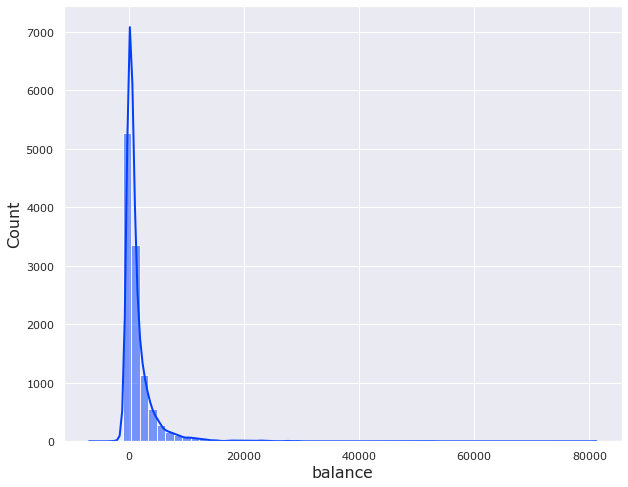

In [97]:
sns.histplot(df['balance'], bins=60, kde=True);

In [98]:
df['balance'].fillna(df['balance'].median(), inplace=True) # заполним медианой вследствие большого хвоста признака

In [99]:
# Также заполним немногочисленные неявные пропуски в job и education
df['job'].replace('unknown', df['job'].mode()[0], inplace=True)
df['education'].replace('unknown', df['education'].mode()[0], inplace=True)

Попробуем убрать выбросы из признака balance по методу Тьюки с подобранными границами

In [100]:
df_tukey = df.copy()

In [101]:
def IQR_outlier(data, feature, lower_scale=1.5, upper_scale=1.5, log=False):
    if log:
        x = pd.Series(np.log(np.where(data[feature] >= 0, data[feature], 0) + 1))
    else:
        x = data[feature]
    q1 = x.quantile(0.25) 
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    print(q1 - lower_scale*iqr, q3 + upper_scale*iqr)
    return data[(x >= (q1 - lower_scale*iqr)) & (x <= (q3 + upper_scale*iqr))]
df_tukey = IQR_outlier(df_tukey, feature='balance', log=False) # поставить Log
df_tukey.shape

-2241.0 4063.0


(10105, 17)

## Часть 2:  Разведывательный анализ

Прежде всего сопоставим распределение меток целевого класса.

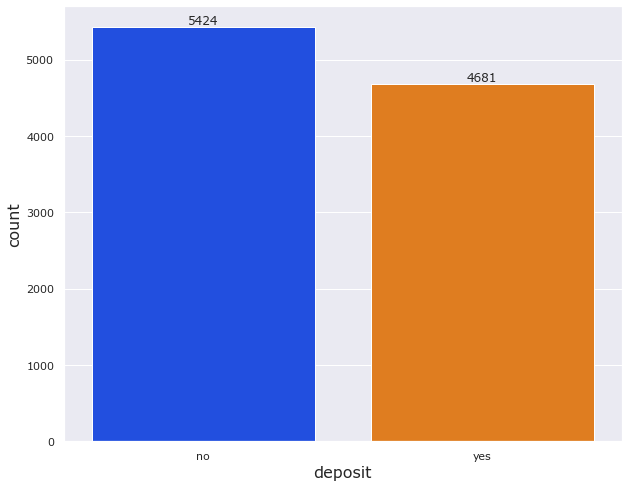

In [102]:
ax = sns.countplot(data=df_tukey, x='deposit', order=['no', 'yes'])
ax.bar_label(ax.containers[0]);

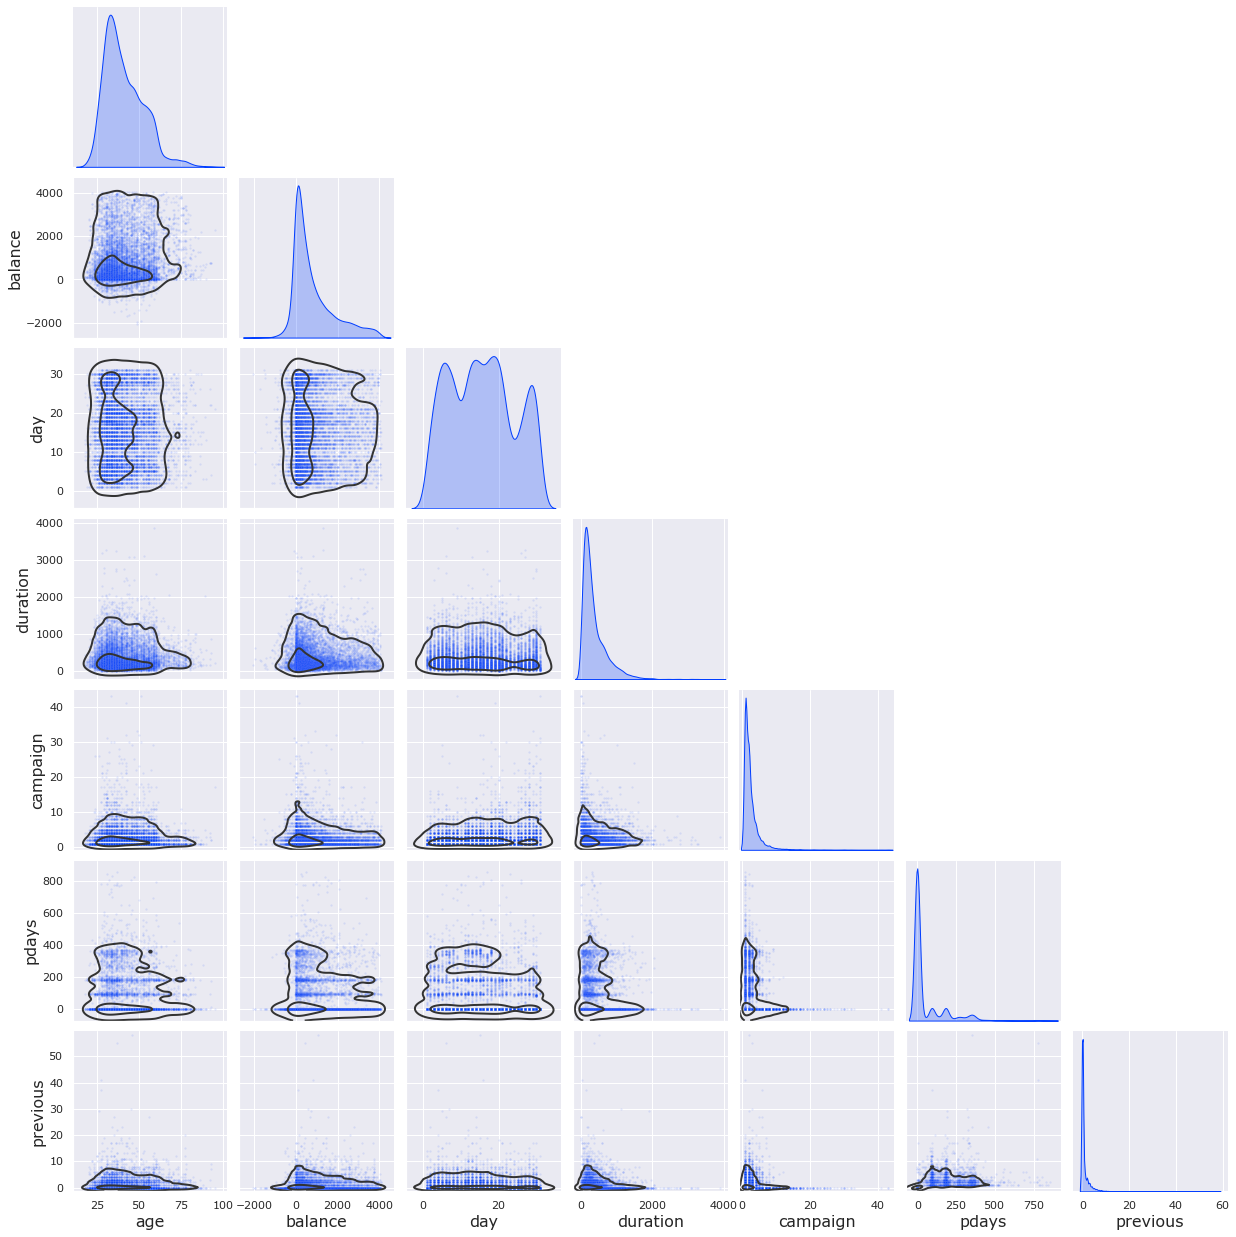

In [103]:
# sns.pairplot(data=df_tukey, diag_kind='kde', corner=True, plot_kws=dict(s=5, alpha=0.1)).map_lower(sns.kdeplot, levels=3, color=".2");

> Распределение 5 из 7 числовых признаков довольно ассиметрично с пиком в нуле. Также отчетливо видна обратная зависимость количества контактов текущей и прошедшей маркетинговых кампаний от продолжительности контакта (графики duration-compaign; duration-previous). Стоит еще отметить, что наибольшее число контактов с наибольшей продолжительностью удается устанавливать с клиентами возрастом от 25 до 50 лет (age-duration;compaign;previous).

In [139]:
df_tukey.describe(percentiles=[0.1, 0.5, 0.75, 0.9]) # описательные статистики количественных переменных

,age,balance,day,duration,campaign,pdays,previous,month_num
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230,6.138644
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795,2.533676
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,1.000000
10%,28.000000,0.000000,4.000000,76.000000,1.000000,-1.000000,0.000000,2.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,6.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000,8.000000
90%,57.000000,2395.200000,28.000000,832.000000,5.000000,193.000000,3.000000,10.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,12.000000


> Максимальное значение признака duration к удивлению велико, вполне ожидаема прямая зависимость вероятности открытия депозита от продолжительности контакта (ну или клиенты общаются с маркетологом около часа о жизни), минимальное же значение наводит на мысль, что контакты длиною менее минуты редко будут венчаться маркетинговым успехом. 
> 
> Скачок значений признака pdays после 0.75-го квантиля кажется аномальным, даже учитывая его ассиметричность. Также как минимум 10% клиентов имеют отрицательный баланс, исходя из житейской логики, они будут открывать депозит с меньшей вероятностью.
> 
> Стоит обратить внимание на признак количества контактов в рамках текущей комапании (`campaign`), у которого чересчур велико максимальное значение, учитывая что с 90% клиентов связывались не более 5 раз.

Разделим клиентов на возрастные подгруппы, преобразуя признак age

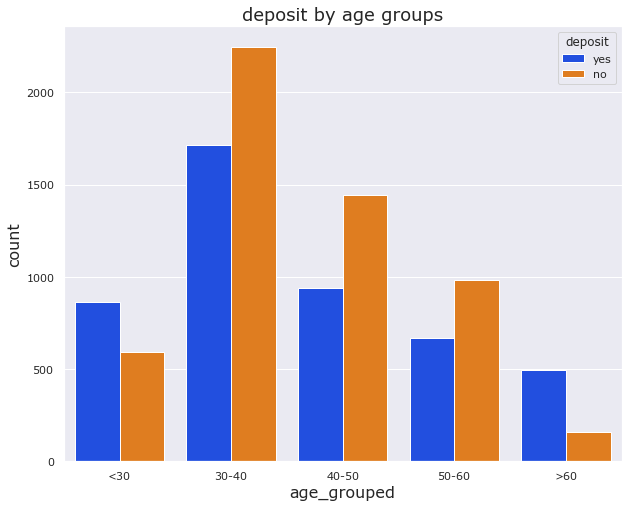

In [140]:
def age_grouping(sample):
    if sample < 30:
        return '<30'
    elif 30 <= sample < 40:
        return '30-40'
    elif 40 <= sample < 50:
        return '40-50'
    elif 50 <= sample < 60:
        return '50-60'
    else:
        return '>60'
df_tukey['age_grouped'] = df['age'].apply(age_grouping)
sns.countplot(data=df_tukey, x='age_grouped', order=['<30', '30-40', '40-50', '50-60', '>60'], hue='deposit').set(
    title='deposit by age groups');

> Интерес представляют группы клиентов моложе 30 и старше 60, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

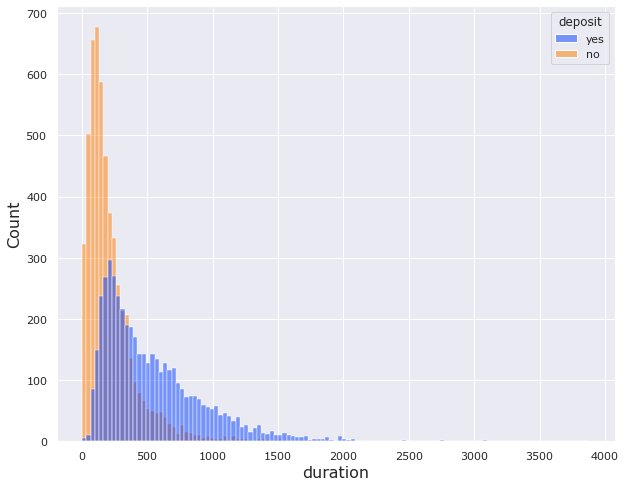

In [141]:
sns.histplot(data=df_tukey, x='duration', hue='deposit');

> Почти все контакты длиннее 11-12 минут завершались открытием депозита, а контакты короче 5 минут чаще всего проваливались.

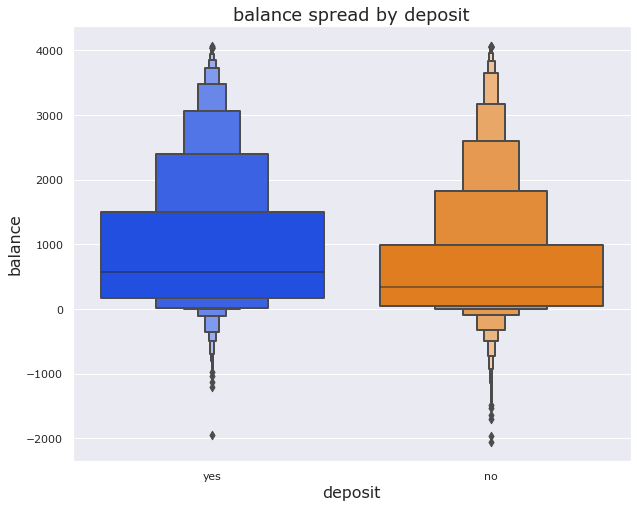

In [142]:
sns.boxenplot(data=df_tukey, x='deposit', y='balance').set(title='balance spread by deposit');

> Разброс баланса **основного**(внутри iqr) количества клиентов, открывших депозит больше, чем у неоткрывших, но в рамках общей картины баланс первых, выше.

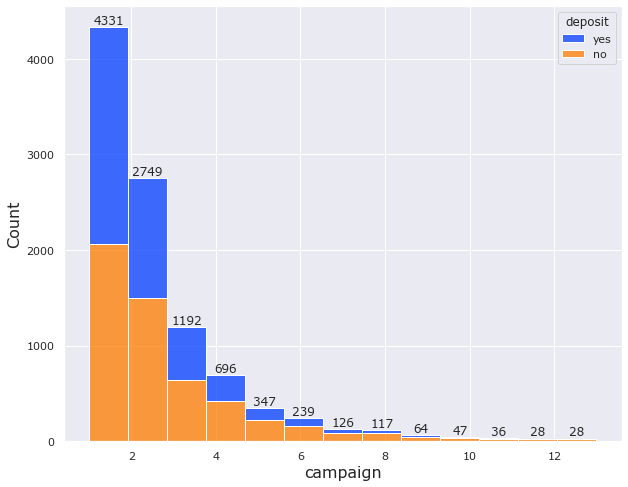

In [143]:
# возьмем для наглядности записи с небольшим относительно максимума количеством контактов 
ax = sns.histplot(data= df_tukey[df_tukey['campaign']<14], x='campaign', bins=13, hue='deposit', multiple="stack")
ax.bar_label(ax.containers[1]);

> Более 70% клиентов, открывших депозит общались с маркетологом 1-2 раза, также из графика явно видно, что связываться с одним клиентом больше 8 раз в рамках одной маркетинговой кампании почти не имеет смысла.

***

In [144]:
print("Описательные статистики категориальных переменных")
df_tukey.describe(include='object')

Описательные статистики категориальных переменных


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit,age_grouped
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2,5
top,management,married,secondary,no,no,no,cellular,may,unknown,no,30-40
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424,3961


> Отсюда можно заключить, что 98% клиентов из данной выборки не просрачивали кредиты; большинство контактов заключались по сотовой связи; и что приизнак результата прошедшей маркетинговой кампании (poutcome) довольно бесполезен вследствие 75% 'unknown' значений.

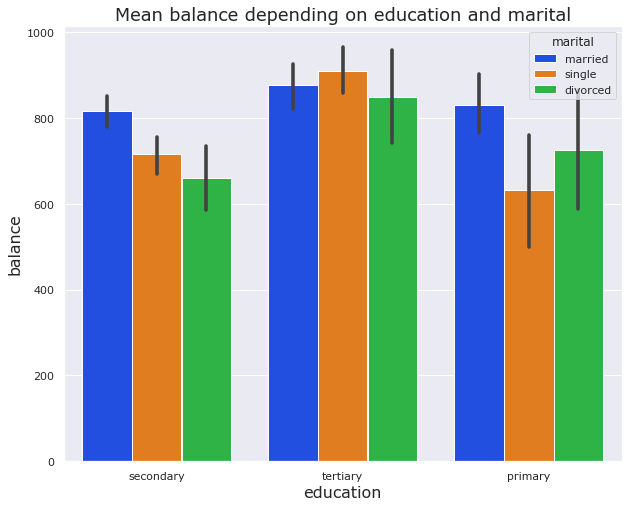

In [145]:
ax = sns.barplot(data=df_tukey, x='education', y='balance', hue='marital')
ax.set_title("Mean balance depending on education and marital");

> Вне зависимости от семейного положения, клиенты с высшим образованием в среднем имеют наибольший средний баланс на счету, что довольно ожидаемо. Однако максимум среднего баланса наблюдается именно у одиноких людей с высшим образованием

Посмотрим на значение целевого признака в разрезе категориальных признаков и времени.<br>
Для начала визуализируем пересечение категорий семейного положения и уровня образования.

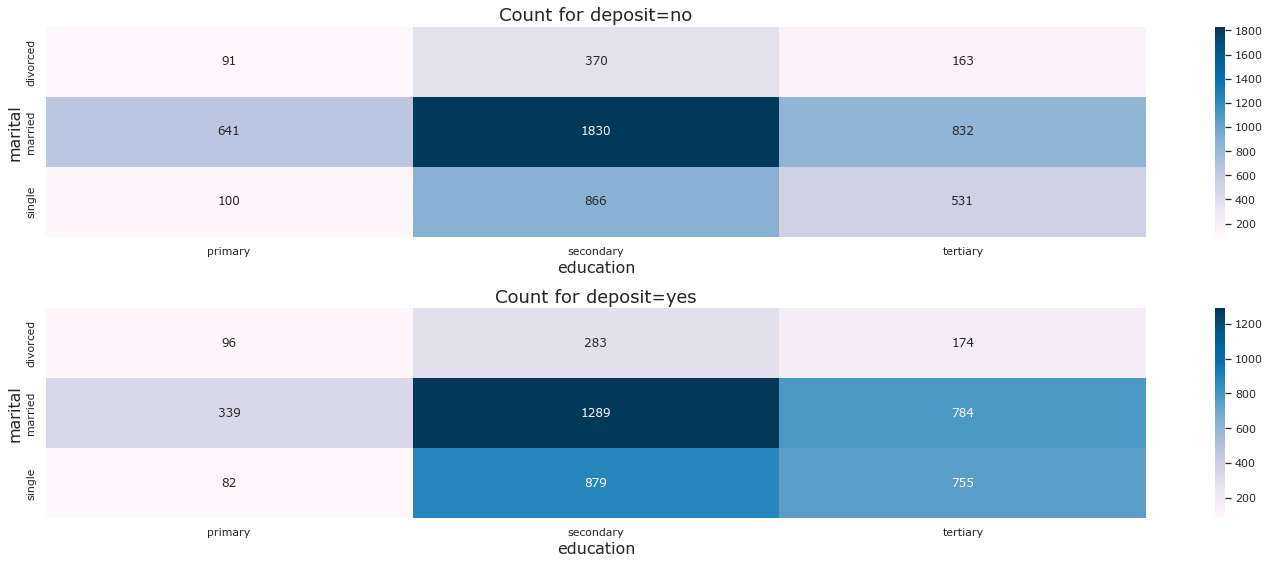

In [146]:
fig, axes = plt.subplots(2, figsize=(20,8))
deposits_list = ['no', 'yes']
for i in range(len(axes)):
    piv = pd.pivot_table(data=df_tukey[df_tukey['deposit']==deposits_list[i]], index='marital', columns='education', 
                                         values='deposit', aggfunc='count')
    sns.heatmap(data=piv, ax=axes[i], cmap='PuBu', annot=True, fmt='d').set(title=f'Count for deposit={deposits_list[i]}')
fig.tight_layout()

> Видно, что пересечение категорий `married-secondary` самое многочисленное в наших данных, однако тенденция к открытию депозита у клиентов с этой парой категорий отрицательная. А одинокие клиенты со средним и высшим образованием, напротив, чуть более склонны к открытию депозита (`single-secondary` и `single-tertiary`).

In [147]:
def month_convert(sample):
    match sample:
        case "jan":
            return 1
        case "feb":
            return 2
        case "mar":
            return 3
        case "apr":
            return 4
        case "may":
            return 5
        case "jun":
            return 6
        case "jul":
            return 7
        case "aug":
            return 8
        case "sep":
            return 9
        case "oct":
            return 10
        case "nov":
            return 11
        case "dec":
            return 12

df_tukey['month_num'] = df_tukey['month'].apply(month_convert).astype('int') # признак номера месяца
# df_tukey.drop('month',axis=1,inplace=True)

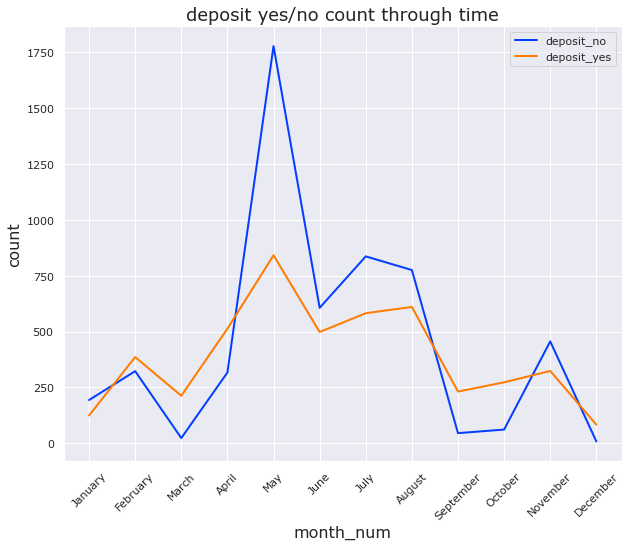

In [148]:
df_dep_month = df_tukey.groupby(['deposit','month_num'])['deposit'].count()
ax = sns.lineplot(data=df_dep_month['no'], label='deposit_no')
sns.lineplot(data=df_dep_month['yes'], label='deposit_yes')
ax.set_title("deposit yes/no count through time")
ax.set_ylabel('count')
ax.set_xticks(range(1,13), labels=pd.to_datetime(range(1,13), format='%m').month_name(), rotation=45);


> Самым неудачным и одновременно удачным месяцом для данной маркетинговой кампании оказался май, по графику можно заключить что наиболее активный период проведения кампании был второй квартал года (апрель, май, июнь).

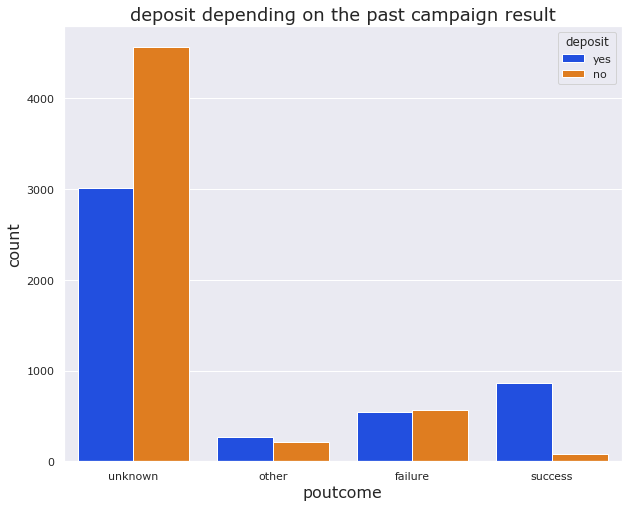

In [149]:
# piv = pd.pivot_table(data=df_tukey, index='deposit', columns='poutcome', values='balance', aggfunc='count')
sns.countplot(data=df_tukey, x='poutcome', hue='deposit').set(title='deposit depending on the past campaign result');

> Как и было сказано выше, признак результатов предыдущей маркетинговой кампании довольно неинформативный из-за большого количества пропусков, но тем не менее почти все успехи предыдущей кампании повторились и в текущей.

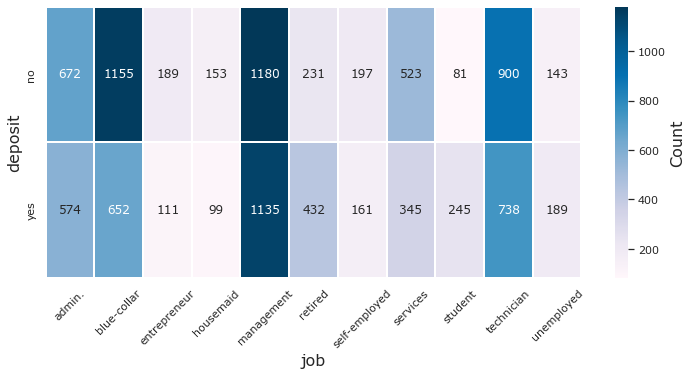

In [150]:
plt.figure(figsize=(12,5))
deposit_by_job = pd.pivot_table(df_tukey, index='deposit', columns='job', values='balance', aggfunc='count')
sns.heatmap(deposit_by_job, cmap='PuBu', linewidths=2, annot=True, fmt='d', cbar_kws={'label': 'Count'}).xaxis.set_tick_params(rotation=45)

>Клиентов, занятых в сфере менеджмента в данных больше всего, как было показано выше в описательных статистиках, они, суля по данным с равной вероятностью соглашаются и отказываются от предложения. Клиенты, занимающиеся физическим трудом (`blue-collar`) склонны отклонять предложения в рамках маркетинговой кампании. Интерес представляют группа ушедших в отставку или на пенсию клиентов `retired`, которые чаще открывают депозиты.

***

## Часть 3: преобразование данных

In [223]:
df_encoded = df_tukey.copy()

Начнем с порядкового кодирования соответствующих признаков и а бинарные признаки, включая целевой приведем к числовому виду

In [224]:
le = OrdinalEncoder()
ord_enc_cols = ['education', 'age_grouped']
binary_cols = ['loan', 'housing', 'default', 'deposit']
df_encoded[ord_enc_cols] = le.fit_transform(df_encoded[ord_enc_cols])
for col in binary_cols:
    df_encoded[col] = df_encoded[col].apply(lambda value: 1 if  value == 'yes' else 0)

One-hot кодирование для номинальных признаков

In [225]:
one_hot_cols = ['job', 'marital', 'contact', 'month', 'poutcome'] 
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols)

Проверим признаки на корреляционную связь, сначала с целевой переменной

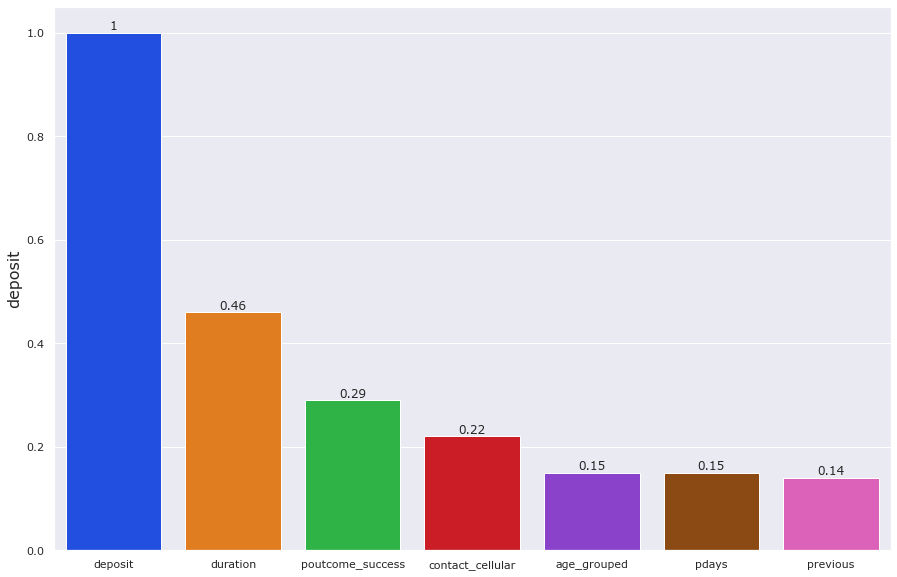

In [226]:
corr_with_target = pd.DataFrame(round(df_encoded.corr()['deposit'].sort_values(ascending=False).nlargest(7),2))
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(data=corr_with_target, x=corr_with_target.index, y=corr_with_target['deposit'])
ax.bar_label(ax.containers[0]);

> Сильной линейной зависимости между целевой переменной и предикторами нет.

##### Так как признаков из-за One-Hot кодирования получилось почти 50, матрица корреляций будет нечитабельна в принципе. Поэтому реализуем нахождения пар признаков, модуль коэффицента корреляции между которыми больше 0.5 следующим образом:

In [227]:
corr_features_pairs = []
corr_values = []
corr_matrix = df_encoded.corr()
for col in corr_matrix:
    tuples = list(corr_matrix[col].items())
    for value in tuples:
        if value[0] != col and (value[1] > 0.5 or value[1] < -0.5):
            if value[0] + '-' + col not in corr_features_pairs:
                corr_features_pairs.append(col + '-' + value[0])
                corr_values.append(abs(value[1]))

И здесь же для удобства визуализируем получившиеся пары и значения коэф. корреляции

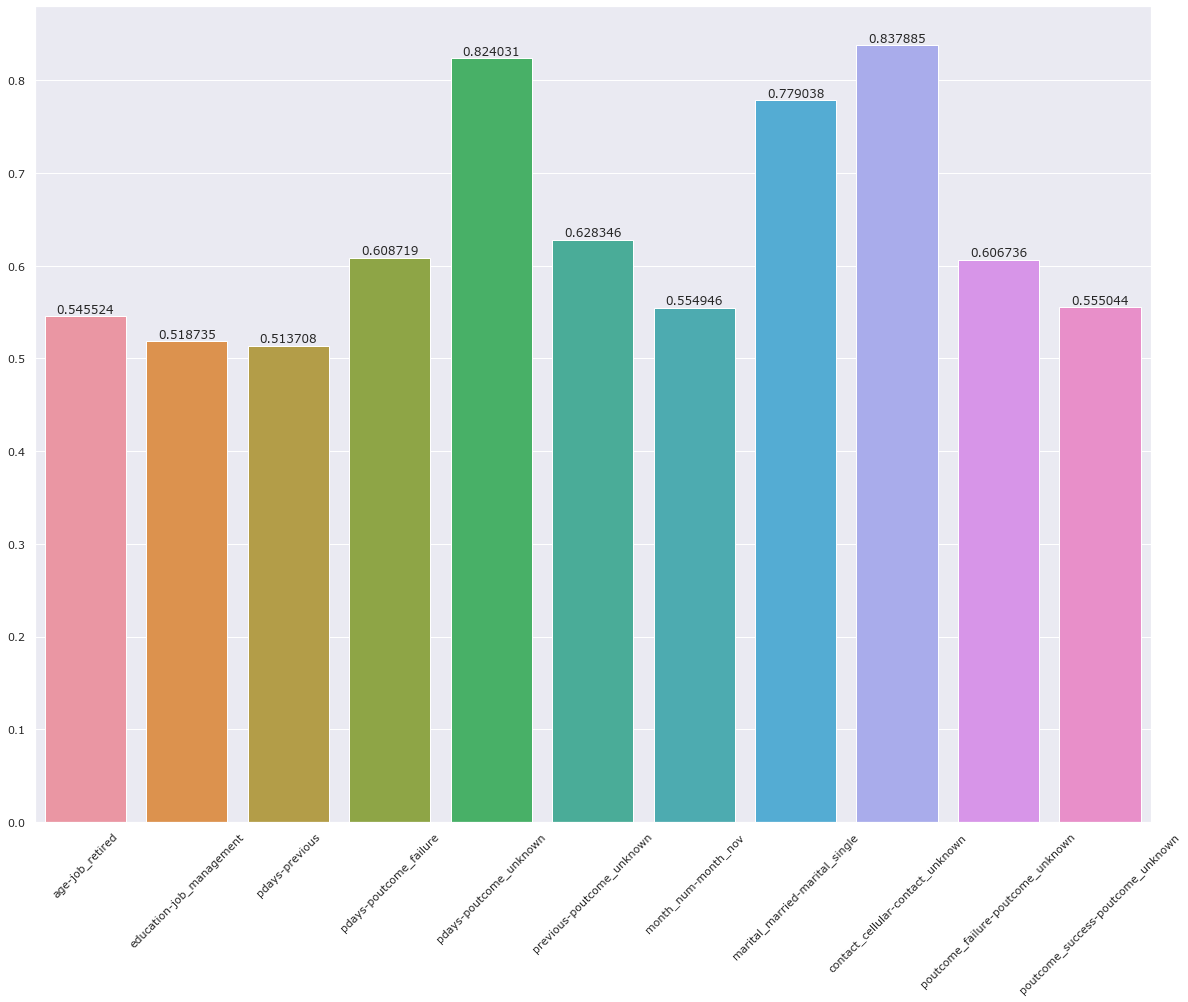

In [228]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=corr_features_pairs, y=corr_values)
ax.xaxis.set_tick_params(rotation=45)
ax.bar_label(ax.containers[0]);

> Максимальная линейная связь в данных прослеживается между двумя парами признаков: `pdays` - `poutcome_unknown` и `contact_cellular` - `contact_unknown`. Удалим признаки с меткой `uknown`.

## !!!!

In [229]:
# df_encoded.drop(['poutcome_unknown', 'contact_unknown'], axis=1, inplace=True)

***

Разделим данные и оставим для последующего обучения модели 15 признаков с помощью селектора `SelectKBest` cо статистическим критерием ANOVA

In [230]:
X = df_encoded.drop(['deposit'], axis=1)
y = df_encoded['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [231]:
skb = SelectKBest(score_func=f_classif, k=15)
X_train_selected = skb.fit_transform(X_train, y_train)
X_test_selected = skb.transform(X_test)

In [232]:
X_train_selected.shape

(6770, 15)

Визуализируем признаки, отобранные селектором и их score по дисперсионному анализу ANOVA

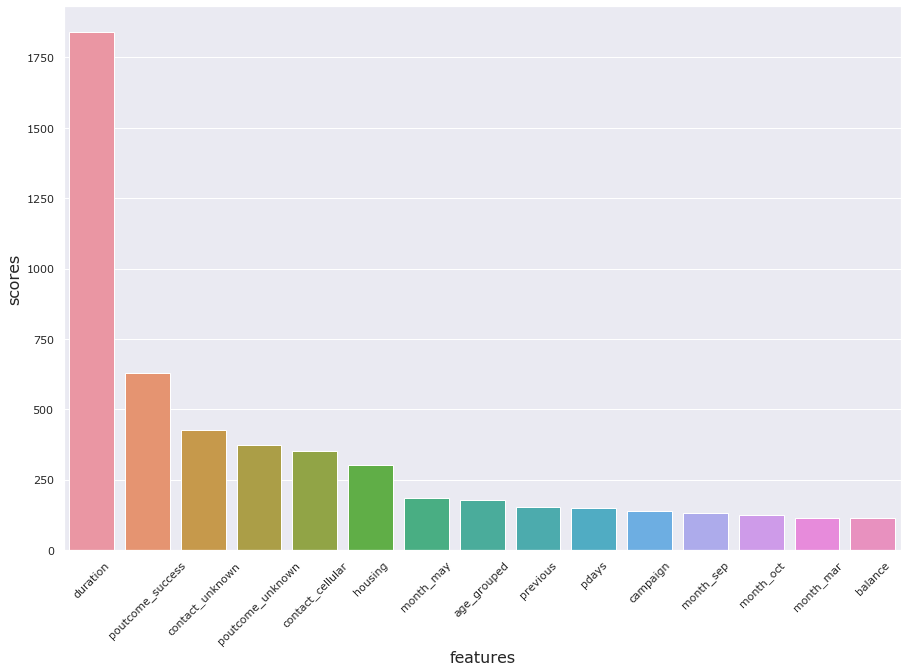

In [233]:
feature_scores = pd.DataFrame({'features':skb.feature_names_in_, 'scores': skb.scores_ }).sort_values(
    by='scores', ascending=False).nlargest(15, columns='scores')
plt.figure(figsize=(15,10))
sns.barplot(data=feature_scores, x='features', y='scores').xaxis.set_tick_params(rotation=45)

Нормализуем данные при помощи MinMaxScaler

In [234]:
mm_scaler = MinMaxScaler()
X_train_selected = mm_scaler.fit_transform(X_train_selected)
X_test_selected = mm_scaler.transform(X_test_selected)

In [235]:
X_test_selected[:,0].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

В качестве baseline обучим:
* Логистическую регрессию

In [331]:
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_selected, y_train)
print("Logistic regression results:")
print(metrics.classification_report(log_reg.predict(X_test_selected), y_test))

Logistic regression results:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1962
           1       0.73      0.82      0.78      1373

    accuracy                           0.80      3335
   macro avg       0.80      0.81      0.80      3335
weighted avg       0.81      0.80      0.80      3335



* И дерево решений с полным перебором небольшого диапозона основных дискретных гиперпараметров с кросс-валидацией

In [332]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[5,6,7,10],
    'min_samples_split': [2,3,5,7,10],
    'min_samples_leaf': [2,3,5,7]
}
gsCV = GridSearchCV(estimator=tree.DecisionTreeClassifier(),
                    param_grid=param_grid,
                    cv=5)
gsCV.fit(X_train_selected, y_train)
gs_dtree = gsCV.best_estimator_
gsCV.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 7}

In [333]:
print(metrics.classification_report(gs_dtree.predict(X_test_selected), y_test))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1763
           1       0.81      0.80      0.80      1572

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



***

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [241]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [242]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [243]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [244]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [245]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna